#### Higher Ground Python Task

##### Compass Calibration Script

Notes
 - All satellites are rotating around the equator at different latitudes
 - Looking for the optimal azimuth based on SatPaq signal strength in dB
 - Want faster than linear time search 

In [1]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from plotnine import ggplot, aes, geom_col, geom_histogram, geom_bar
import random
import statistics

##### Read data into pandas dataframes for plotting

In [2]:
df_G12 = pd.read_excel('G12_Test_RX.csv.xlsx')
print(df_G12.shape)
df_G12.head()

(455, 5)


,Azimuth,Elevation,Esn0,Angle Diff,Average Esn0
0,0,46,-0.8,90,NaN
1,0,46,-5.2,90,NaN
2,0,46,-4.8,90,NaN
3,0,46,-8.0,90,NaN
4,0,46,-8.4,90,-5.44


In [3]:
df_G3C = pd.read_excel('G3C_Test_RX.csv.xlsx')
print(df_G3C.shape)
df_G3C.head()

(455, 5)


,Azimuth,Elevation,Esn0,Angle Diff,Average Esn0
0,0,38,-1.2,90,NaN
1,0,38,-3.6,90,NaN
2,0,38,-6.0,90,NaN
3,0,38,-8.4,90,NaN
4,0,38,-8.4,90,-5.52


##### Plot Data

##### Using matplotlib

Text(0.5, 0, 'Azimuth')

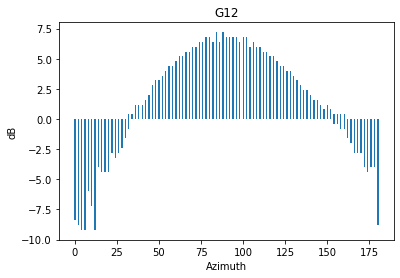

In [4]:
plt.bar(df_G12['Azimuth'], df_G12['Esn0'])
plt.title('G12')
plt.ylabel('dB')
plt.xlabel('Azimuth')

Text(0.5, 0, 'Azimuth')

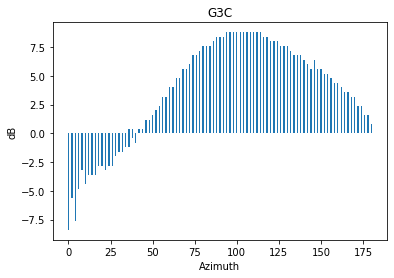

In [5]:
plt.bar(df_G3C['Azimuth'], df_G3C['Esn0'])
plt.title('G3C')
plt.ylabel('dB')
plt.xlabel('Azimuth')

##### using ggplot

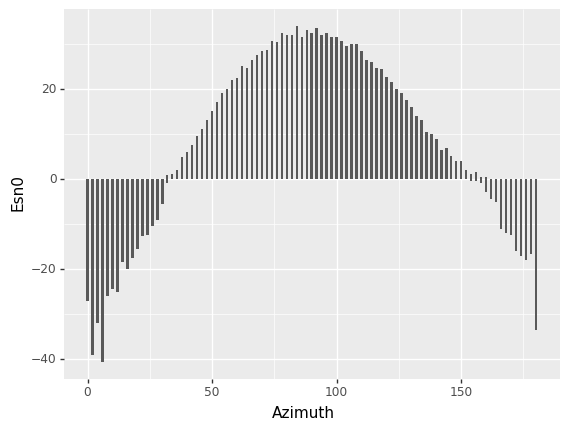

<ggplot: (90443671827)>

In [6]:
ggplot(df_G12, aes(x="Azimuth", y = "Esn0")) + geom_bar(stat='identity', width = 1)

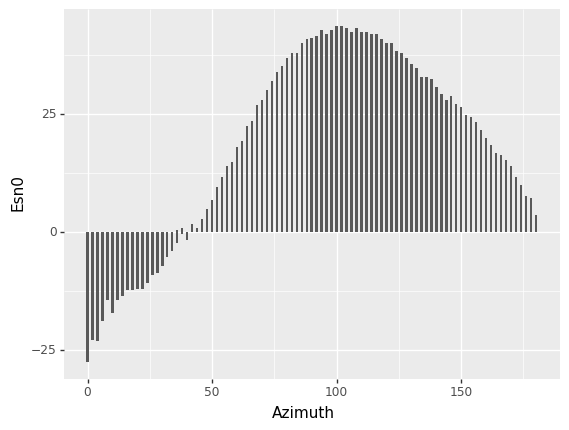

<ggplot: (90443781750)>

In [7]:
ggplot(df_G3C, aes(x="Azimuth", y = "Esn0")) + geom_bar(stat='identity', width = 1)

#### Scratch work: Finding the SatPaq position based on signal strength and known location of the satellite

In [8]:
# random starting position
start = random.randrange(-90, 90, 2)
print(start)

-68


#### Circle shift signal so we don't know where we are
##### Example of Understanding: 
- If start = 60 we want to "shift the values by 60 degrees" or np.roll so that values measured at one angle are shifted in a list to where values measured at 60 degrees away are. 
- If we group readings by the number of readings by the number of readings per angle, we need to roll by (60/2)
  - 60/2 because we are measuring every 2 degrees


In [9]:
#group by readings per angle
num_readings = 5

#these loops jump by 5 each iteration but only read number of num_readings, this willbe useful for testing
GF12_signals = []
for i in range(0,len(df_G12['Esn0']), 5):
    GF12_signals.append(list(df_G12['Esn0'][i:i+num_readings]))
#print(GF12_signals)

GF3C_signals = []
for i in range(0,len(df_G3C['Esn0']), 5):
    GF3C_signals.append(list(df_G3C['Esn0'][i:i+num_readings]))
#print(GF3C_signals)


roll = (start//2)
GF12_W129 = np.array(GF12_signals)
GF3C_W95 = np.array(GF3C_signals)

#shift
GF12_W129 = np.roll(GF12_W129,roll, axis = 0)
GF3C_W95 = np.roll(GF3C_W95,roll,axis = 0)

After the roll, we are lost, I am assuming, based on the given data, that the strongest signal is between 90 degrees left and 90 degrees right for a total 180 degree range of where we are facing. If we take 5 readings every time we check a position for a signal strength each check takes 2 seconds. The step size of the stepper motor is 2 degrees we have 90 total signals to check (if we calculate the averages). We can use the difference between the starting position and strongest signal position for the offset and use the offset and known longitude of the satellites to calculate a starting position. If we use a stepper motor at 2 revolutions per second we'll get 720 degrees per second so 2 degree turn would take around 0.003 seconds (most step at 1.8 degrees though right...).

We can use a modified binary search to find the peak.

#### Method 1: Binary search(es)

In [10]:
def find_peak(signals, jump):
    l,r = 0, len(signals)-1
    total_read_time = 0
    total_turn_time = 0
    starting = l + (r-l)//2
    while l + jump < r:
        #the first iteration of mid is the unknown starting position, afterward, it is adjusted so we need to add in the turn time
        try:
            total_turn_time += abs(mid - (l + (r - l) // 2))*0.003
        except:
            total_turn_time +=0
        mid = l + (r - l) // 2
        
        #the next if requires x readings per turn = x * 0.4 seconds 
        total_read_time += 2*(len(signals[mid]) * 0.4)
        
        #plus time per turn = jump/turn size * 0.003 seconds
        total_turn_time += (jump * 0.003)
        
        #if the direction we are pointing is less than 
        if statistics.mean(signals[mid]) < statistics.mean(signals[mid+jump]):
            l = mid + jump
        else:
            r = mid 
    angle_offset = 2*(starting - mid)
    signal_strength = statistics.mean(signals[mid])
    peak = mid
    #print(total_read_time, total_turn_time)
    total_time = total_read_time + total_turn_time
    return signal_strength, total_time, angle_offset, peak

In [11]:
find_peak(GF12_W129,2)

(5.76, 20.159, 86, 2)

##### Read time is very significant. Above is the total_read_time (top left), and total_turn_time (top right). Below it is signal_strength, total_time, angle_offset, peak. 

Plot distribution to visualize where the search ended up vs where the actual peak was. As we can see it found the peak around index 78, where the best signal strength would be found.

Text(0.5, 0, 'Azimuth')

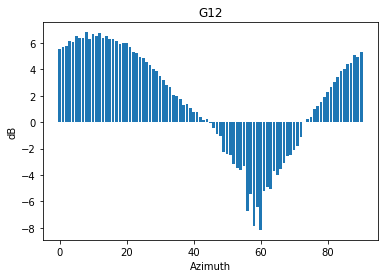

In [12]:
plt.bar([x for x in range(0,91)],[statistics.mean(x) for x in GF12_W129])
plt.title('G12')
plt.ylabel('dB')
plt.xlabel('Azimuth')

##### Try same thing for GF3C data

In [13]:
find_peak(GF3C_W95,5)

(8.48, 16.186, 52, 19)

Text(0.5, 0, 'Azimuth')

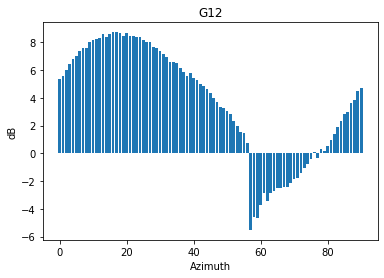

In [14]:
plt.bar([x for x in range(0,91)],[statistics.mean(x) for x in GF3C_W95])
plt.title('G12')
plt.ylabel('dB')
plt.xlabel('Azimuth')

#### Trial Function with binary search function

In [15]:
def search_params(signals, num_readings = 5, step_size = 2, sat_longitude = 129,shift_angle = 60):
    #random starting position offset
    true_start = 90-shift
    
    #group signals by number of readings
    grouped_signals = []
    for i in range(0,len(signals['Esn0']), 5):
        grouped_signals.append(signals['Esn0'][i:i+num_readings])
    
    #rotate/circle shift readings
    signals = np.array(signals)
    shifted_signals = np.roll(grouped_signals, (shift_angle//2), axis = 0)
    
    #search for peak
    signal_strength, time, offset, peak = find_peak(shifted_signals,step_size)
    final_angle = peak*2 - shift_angle
    
    position_estimate = sat_longitude + offset
    
    return signal_strength, time, offset, position_estimate, true_start, final_angle

#### Compass calibration trials for G3C satellite

In [16]:
G3C_2step_2read = pd.DataFrame(columns=['Signal Strengths','Times','Offset','Shift Angle','Position Estimate', 'True Start','Error', 'Final Angle'])
for _ in range(25):
    shift = random.randrange(-90, 90, 2)
    ss,t,o,pe,tsp, final = search_params(df_G3C,2,2,95,shift)
    err = (pe - tsp)
    G3C_2step_2read = G3C_2step_2read.append({'Signal Strengths':ss, 'Times':t, 'Position Estimate':pe,'Error':err,'Offset':o,'True Start':tsp, 'Shift Angle':shift, 'Final Angle': final}, ignore_index=True)




In [17]:
G3C_2step_2read

,Signal Strengths,Times,Offset,Shift Angle,Position Estimate,True Start,Error,Final Angle
0,8.4,8.159,-54.0,52.0,41.0,38.0,3.0,92.0
1,8.2,8.162,72.0,-70.0,167.0,160.0,7.0,88.0
2,8.2,8.156,-20.0,20.0,75.0,70.0,5.0,90.0
3,8.8,8.162,4.0,-8.0,99.0,98.0,1.0,94.0
4,8.4,8.159,38.0,-60.0,133.0,150.0,-17.0,112.0
5,8.8,8.159,14.0,-18.0,109.0,108.0,1.0,94.0
6,8.6,8.159,-54.0,40.0,41.0,50.0,-9.0,104.0
7,8.8,8.159,14.0,-22.0,109.0,112.0,-3.0,98.0
8,8.6,8.162,72.0,-86.0,167.0,176.0,-9.0,104.0
9,8.4,8.156,-8.0,6.0,87.0,84.0,3.0,92.0


##### Edge Cases Found when starting at 70 and 78 rotation with step size of 2

In [18]:
G3C_2step_2read_edges = pd.DataFrame(columns=['Signal Strengths','Times','Offset','Shift Angle','Position Estimate', 'True Start','Error', 'Final Angle'])
for shift in range(60,80,2):
    ss,t,o,pe,tsp, final = search_params(df_G3C,2,2,95,shift)
    err = (pe - tsp)
    G3C_2step_2read_edges = G3C_2step_2read_edges.append({'Signal Strengths':ss, 'Times':t,'Error':err, 'Position Estimate':pe,'Offset':o,'True Start':tsp, 'Shift Angle':shift, 'Final Angle': final}, ignore_index=True)

G3C_2step_2read_edges

,Signal Strengths,Times,Offset,Shift Angle,Position Estimate,True Start,Error,Final Angle
0,8.2,8.159,-66.0,60.0,29.0,30.0,-1.0,96.0
1,8.8,8.159,-66.0,62.0,29.0,28.0,1.0,94.0
2,8.6,8.159,-78.0,64.0,17.0,26.0,-9.0,104.0
3,8.2,8.159,-66.0,66.0,29.0,24.0,5.0,90.0
4,8.2,8.159,-66.0,68.0,29.0,22.0,7.0,88.0
5,8.4,8.159,86.0,70.0,181.0,20.0,161.0,-66.0
6,8.2,8.159,-78.0,72.0,17.0,18.0,-1.0,96.0
7,8.8,8.159,-78.0,74.0,17.0,16.0,1.0,94.0
8,8.2,6.547,-82.0,76.0,13.0,14.0,-1.0,96.0
9,8.8,8.159,86.0,78.0,181.0,12.0,169.0,-74.0


##### Visaulization to show why the edge cases may exist in G3C

In [19]:
#group by readings per angle
num_readings = 5

#these loops jump by 5 each iteration but only read number of num_readings, this willbe useful for testing
GF3C_signals = []
for i in range(0,len(df_G3C['Esn0']), 5):
    GF3C_signals.append(list(df_G3C['Esn0'][i:i+num_readings]))
#print(GF3C_signals)


roll = (70//2)
GF3C_W95 = np.array(GF3C_signals)


#shift
GF3C_W95_70 = np.roll(GF3C_W95,70//2, axis = 0)
GF3C_W95_78 = np.roll(GF3C_W95,78//2,axis = 0)

Text(0.5, 0, 'Azimuth')

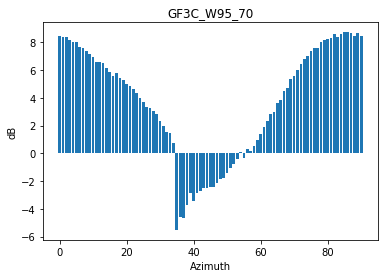

In [20]:
plt.bar([x for x in range(0,91)],[statistics.mean(x) for x in GF3C_W95_70])
plt.title('GF3C_W95_70')
plt.ylabel('dB')
plt.xlabel('Azimuth')

Text(0.5, 0, 'Azimuth')

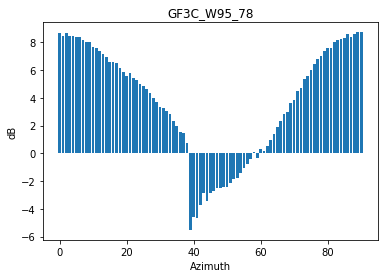

In [21]:
plt.bar([x for x in range(0,91)],[statistics.mean(x) for x in GF3C_W95_78])
plt.title('GF3C_W95_78')
plt.ylabel('dB')
plt.xlabel('Azimuth')

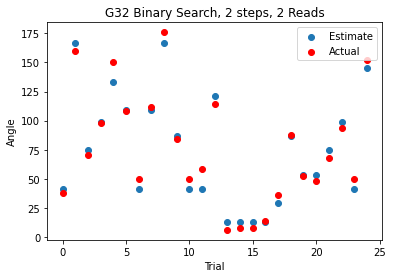

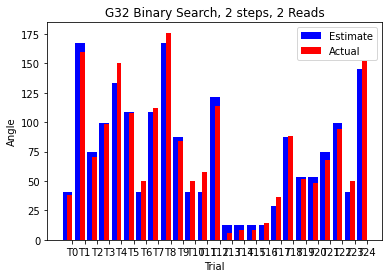

In [22]:
#scatter
plt.scatter(G3C_2step_2read.index,G3C_2step_2read['Position Estimate'],label='Estimate')
plt.scatter(G3C_2step_2read.index,G3C_2step_2read['True Start'], color='r',label = 'Actual')
plt.xlabel('Trial')
plt.ylabel('Angle')
plt.title('G32 Binary Search, 2 steps, 2 Reads')
plt.legend(loc= 'upper right')
plt.show()

#bar
width = 0.8
plt.bar(G3C_2step_2read.index, G3C_2step_2read['Position Estimate'], width=width, color='b', label='Estimate')
plt.bar([i+0.25*width for i in G3C_2step_2read.index], G3C_2step_2read['True Start'], width=0.5*width, color='r', alpha=1, label = 'Actual')
plt.title('G32 Binary Search, 2 steps, 2 Reads')
plt.xticks(G3C_2step_2read.index+width/2., ['T{}'.format(i) for i in range(len(G3C_2step_2read['Position Estimate']))] )
plt.xlabel('Trial')
plt.ylabel('Angle')
plt.legend()
plt.show()

#### Compass calibration Trials for G12 satellite with position at 129

In [23]:
G12_3step_5read = pd.DataFrame(columns=['Signal Strengths','Times','Offset','Shift Angle','Position Estimate', 'True Start','Error', 'Final Angle'])
for i in range(25):
    shift = random.randrange(-90, 90, 2)
    ss,t,o,pe,tsp, final = search_params(df_G12,5,3,129,shift)
    err = (pe - tsp)
    G12_3step_5read = G12_3step_5read.append({'Signal Strengths':ss, 'Times':t, 'Position Estimate':pe,'Offset':o,'True Start':tsp, 'Error':err, 'Shift Angle':shift, 'Final Angle': final}, ignore_index=True)



In [24]:
G12_3step_5read

,Signal Strengths,Times,Offset,Shift Angle,Position Estimate,True Start,Error,Final Angle
0,6.72,20.174,-58.0,56.0,71.0,34.0,37.0,92.0
1,6.32,20.177,36.0,-32.0,165.0,122.0,43.0,86.0
2,6.72,20.177,-36.0,34.0,93.0,56.0,37.0,92.0
3,6.16,20.174,-10.0,26.0,119.0,64.0,55.0,74.0
4,6.16,16.156,-16.0,32.0,113.0,58.0,55.0,74.0
5,6.64,20.174,-10.0,12.0,119.0,78.0,41.0,88.0
6,6.72,20.174,-10.0,8.0,119.0,82.0,37.0,92.0
7,6.80,20.177,-36.0,42.0,93.0,48.0,45.0,84.0
8,6.32,16.162,8.0,-4.0,137.0,94.0,43.0,86.0
9,6.80,20.174,-10.0,16.0,119.0,74.0,45.0,84.0


The differnces between estimate and true start for G12 are much worse because the the strongest angle is not at the 129 angle but instead also around 95.

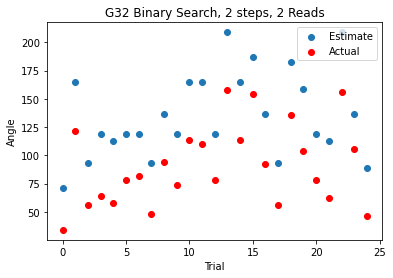

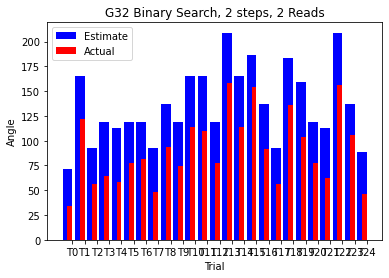

In [25]:
#scatter
plt.scatter(G12_3step_5read.index,G12_3step_5read['Position Estimate'],label='Estimate')
plt.scatter(G12_3step_5read.index,G12_3step_5read['True Start'], color='r',label = 'Actual')
plt.xlabel('Trial')
plt.ylabel('Angle')
plt.title('G32 Binary Search, 2 steps, 2 Reads')
plt.legend(loc= 'upper right')
plt.show()

#bar
width = 0.8
plt.bar(G12_3step_5read.index, G12_3step_5read['Position Estimate'], width=width, color='b', label='Estimate')
plt.bar([i+0.25*width for i in G12_3step_5read.index], G12_3step_5read['True Start'], width=0.5*width, color='r', alpha=1, label = 'Actual')
plt.title('G32 Binary Search, 2 steps, 2 Reads')
plt.xticks(G3C_2step_2read.index+width/2., ['T{}'.format(i) for i in range(len(G3C_2step_2read['Position Estimate']))] )
plt.xlabel('Trial')
plt.ylabel('Angle')
plt.legend()
plt.show()

#### Compass calibration Trials for G12 satellite with position at 96

In [26]:
G12_3step_5read = pd.DataFrame(columns=['Signal Strengths','Times','Offset','Shift Angle','Position Estimate', 'True Start','Error', 'Final Angle'])
for i in range(25):
    shift = random.randrange(-90, 90, 2)
    ss,t,o,pe,tsp, final = search_params(df_G12,5,3,96,shift)
    err = (pe - tsp)
    G12_3step_5read = G12_3step_5read.append({'Signal Strengths':ss, 'Times':t, 'Position Estimate':pe,'Offset':o,'True Start':tsp, 'Error':err, 'Shift Angle':shift, 'Final Angle': final}, ignore_index=True)



In [27]:
G12_3step_5read

,Signal Strengths,Times,Offset,Shift Angle,Position Estimate,True Start,Error,Final Angle
0,6.16,16.159,30.0,-14.0,126.0,104.0,22.0,74.0
1,6.48,20.174,-10.0,22.0,86.0,68.0,18.0,78.0
2,6.16,16.159,30.0,-14.0,126.0,104.0,22.0,74.0
3,6.08,20.177,-36.0,50.0,60.0,40.0,20.0,76.0
4,6.64,16.162,8.0,-6.0,104.0,96.0,8.0,88.0
5,6.48,16.162,-84.0,84.0,12.0,6.0,6.0,90.0
6,6.32,16.162,8.0,-4.0,104.0,94.0,10.0,86.0
7,6.40,16.162,-84.0,-90.0,12.0,180.0,-168.0,264.0
8,6.32,16.162,8.0,-4.0,104.0,94.0,10.0,86.0
9,6.08,20.177,-36.0,50.0,60.0,40.0,20.0,76.0


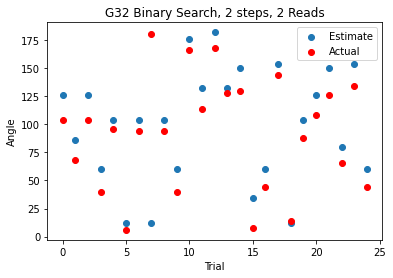

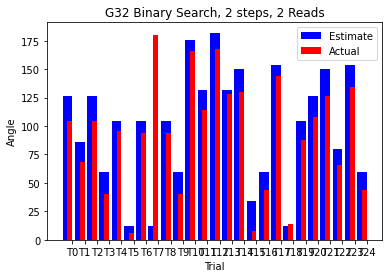

In [28]:
#scatter
plt.scatter(G12_3step_5read.index,G12_3step_5read['Position Estimate'],label='Estimate')
plt.scatter(G12_3step_5read.index,G12_3step_5read['True Start'], color='r',label = 'Actual')
plt.xlabel('Trial')
plt.ylabel('Angle')
plt.title('G32 Binary Search, 2 steps, 2 Reads')
plt.legend(loc= 'upper right')
plt.show()

#bar
width = 0.8
plt.bar(G12_3step_5read.index, G12_3step_5read['Position Estimate'], width=width, color='b', label='Estimate')
plt.bar([i+0.25*width for i in G12_3step_5read.index], G12_3step_5read['True Start'], width=0.5*width, color='r', alpha=1, label = 'Actual')
plt.title('G32 Binary Search, 2 steps, 2 Reads')
plt.xticks(G3C_2step_2read.index+width/2., ['T{}'.format(i) for i in range(len(G3C_2step_2read['Position Estimate']))] )
plt.xlabel('Trial')
plt.ylabel('Angle')
plt.legend()
plt.show()

#### Graphing different times of different strategies
##### Strategy adjustments
- Different step size or turn of stepper motor in binary search
- Different number of readings 

In [29]:
def algorithm_differences(signals_df, longitude):
    final_df = pd.DataFrame(columns=['Step Size','Number of Readings','Average Total Time','Average Error'])
    
    steps_for_search = [1,2,3,5,6,10]
    diff_num_readings = [2,3,4,5]
    for s in steps_for_search:
        for n in diff_num_readings:
            trial_df = pd.DataFrame(columns=['Signal Strengths','Times','Offset','Shift Angle','Position Estimate', 'True Start','Error', 'Final Angle'])
            #5 random shifts
            for _ in range(5):
                shift = random.randrange(-90, 90, 2)
                #print(s,n,shift)
                ss,t,o,pe,tsp, final = search_params(signals_df,n,s,longitude,shift)
                err = (pe - tsp)
                trial_df = trial_df.append({'Signal Strengths':ss, 'Times':t, 'Position Estimate':pe,'Offset':o,'True Start':tsp, 'Error':err, 'Shift Angle':shift, 'Final Angle': final}, ignore_index=True)
                #print(trial_df)
            avg_error = trial_df["Error"].mean()
            avg_time = trial_df["Times"].mean()
            final_df = final_df.append({'Step Size': s, 'Number of Readings':n, 'Average Total Time':avg_time, 'Average Error':avg_error}, ignore_index=True)
    return final_df
            

In [30]:
df_G3C_diff = algorithm_differences(df_G3C,95)

In [31]:
df_G3C_diff

,Step Size,Number of Readings,Average Total Time,Average Error
0,1.0,2.0,9.7524,98.2
1,1.0,3.0,14.0706,83.8
2,1.0,4.0,18.7118,110.2
3,1.0,5.0,22.5488,26.2
4,2.0,2.0,8.1578,19.4
5,2.0,3.0,12.1584,54.2
6,2.0,4.0,16.1584,66.2
7,2.0,5.0,20.1578,26.6
8,3.0,2.0,7.5292,62.6
9,3.0,3.0,10.2420,78.6


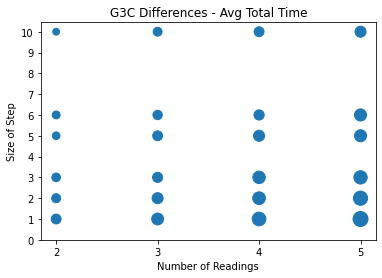

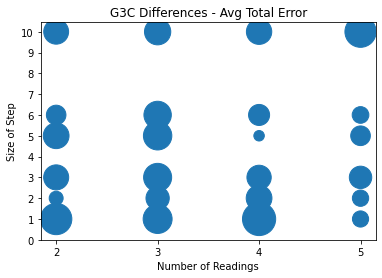

In [32]:
plt.scatter(x = df_G3C_diff['Number of Readings'], y = df_G3C_diff['Step Size'], s = [s*10 for s in df_G3C_diff['Average Total Time']])
plt.xlabel('Number of Readings')
plt.ylabel('Size of Step')
plt.title('G3C Differences - Avg Total Time')
plt.xticks([2,3,4,5])
plt.yticks([x for x in range(11)])
plt.show()

plt.scatter(x = df_G3C_diff['Number of Readings'], y = df_G3C_diff['Step Size'], s = [s*10 for s in df_G3C_diff['Average Error']])
plt.xlabel('Number of Readings')
plt.ylabel('Size of Step')
plt.title('G3C Differences - Avg Total Error')
plt.xticks([2,3,4,5])
plt.yticks([x for x in range(11)])
plt.show()

In [33]:
df_G12_diff = algorithm_differences(df_G12,129)

In [34]:
df_G12_diff

,Step Size,Number of Readings,Average Total Time,Average Error
0,1.0,2.0,9.4312,82.2
1,1.0,3.0,14.5512,59.4
2,1.0,4.0,18.0700,127.4
3,1.0,5.0,24.1512,153.8
4,2.0,2.0,8.1596,132.2
5,2.0,3.0,12.1590,83.8
6,2.0,4.0,16.1590,81.4
7,2.0,5.0,20.1584,104.2
8,3.0,2.0,7.5298,110.6
9,3.0,3.0,10.7250,90.2


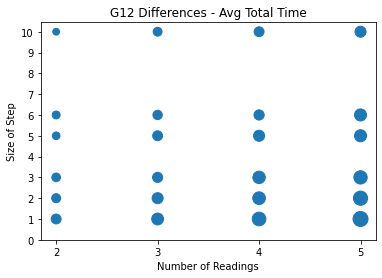

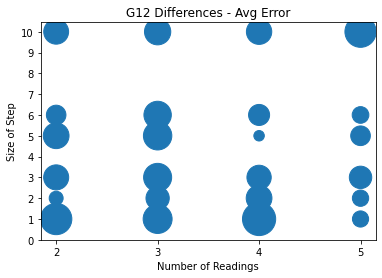

In [35]:
plt.scatter(x = df_G12_diff['Number of Readings'], y = df_G12_diff['Step Size'], s = [s*10 for s in df_G3C_diff['Average Total Time']])
plt.xlabel('Number of Readings')
plt.ylabel('Size of Step')
plt.title('G12 Differences - Avg Total Time')
plt.xticks([2,3,4,5])
plt.yticks([x for x in range(11)])
plt.show()

plt.scatter(x = df_G12_diff['Number of Readings'], y = df_G12_diff['Step Size'], s = [s*10 for s in df_G3C_diff['Average Error']])
plt.xlabel('Number of Readings')
plt.ylabel('Size of Step')
plt.title('G12 Differences - Avg Error')
plt.xticks([2,3,4,5])
plt.yticks([x for x in range(11)])
plt.show()

In [36]:
def trivial_analysis(signals, readings):
    grouped_signals = []
    for i in range(0,len(signals['Esn0']), 5):
            grouped_signals.append(signals['Esn0'][i:i+num_readings])
            
    five_reading_averages = [float(statistics.mean(s)) for s in grouped_signals]
    actual_max = max(five_reading_averages)
    actual_max_index = five_reading_averages.index(actual_max)
    print(actual_max_index)
    print(grouped_signals[50])
    Max = 0
    for angle in range(len(grouped_signals)):
        reading = statistics.mean(grouped_signals[angle])
        if reading > Max:
            Max = reading
            
    print(grouped_signals[int(Max)])
    return Max, actual_max, angle, actual_max,(Max - actual_max), (angle - actual_max_index)*2    

In [286]:
trivial_analysis(df_G3C, 3)

50
250    8.8
251    8.8
252    8.4
253    8.8
254    8.8
Name: Esn0, dtype: float64
40   -3.6
41   -2.4
42   -2.4
43   -2.0
44   -2.0
Name: Esn0, dtype: float64


(8.72, 8.72, 90, 8.72, 0.0, 80)